# Comparison of U.S. newspapers' longitudinal use of *risk words*

### [Daniel McDonald](mailto:mcdonaldd@unimelb.edu.au?Subject=IPython%20NYT%20risk%20project), [Jens Zinn](mailto:jzinn@unimelb.edu.au?Subject=IPython%20NYT%20risk%20project), University of Melbourne

> In this notebook, we build on a preliminary investigation of risk words in *The New York Times*, looking at five additional mainstream U.S. newspapers. See our [GitHub repository](https://www.github.com/interrogator/risk), [IPython Notebook](https://github.com/interrogator/risk/blob/master/risk.ipynb), or [project report](https://raw.githubusercontent.com/interrogator/risk/master/risk_report.pdf) for more information. The theoretical underpinnings of our work, for example, are outlined in detail in the report.

> This Notebook assumes its reader has basic familiarity with **Python** and **key linguistic concepts**, such as word class, syntax, and lemma.

## Introduction: sociology, linguistics, code

Sociologists such as Ulrich Beck and Anthony Giddens have characterised late modernity as *a risk society*, where risk plays an increasingly central role in both institutional structures and everyday life.

Functional linguists are interested in mapping the ways in which words and wordings come together to both construct and represent particular discourses and ideologies. Over the past fifty years, linguists working within functional traditions have mapped out in detail how language is employed by its users as a resource for negotiating interpersonal relationships and for representing doings and happenings in the world, or in consciousness.

Assuming that an increasing salience of *risk* in society will at least partly be reflected in the ways in which risk is discussed, it should therefore be possible to use real-world communication about risk to empirically examine sociological claims.

A number of technological developments make it possible to investigate risk semantics on a large scale:

1. Large, well-organised digital collections of news articles
2. Tools for annotating digital text with linguistic information, such as word classes and grammatical structure
3. Programming languages, libraries and modules that can extract useful information from these annotations

That said, the use of corpus linguistics for discourse analysis is a relatively recent development, with available tools and methods still somewhat behind the state of the art resources available in computaional linguistics, natural language processing, etc.

Accordingly, we use [*corpkit*](https://www.github.com/interrogator/corpkit), a purpose-built Python module for interrogating parsed corpora. The tool is also available as a graphical application, documented and downloadable [here](http://interrogator.github.io/corpkit/). Though our investigation could be performed using the graphical interface, we have instead opted for the command-line tools, which offer more flexibility, especially when working with multiple corpora simultaneously.

## Aim of the investigation

Our main interest was in determining **whether findings from our investigation of the NYT could be generalised to other major U.S. newspapers.**

This investigation makes it possible to describe, and hopefully explain, how risk words have behaved longitudinally in mainstream U.S. newspapers. Later work will connect these findings more explicitly to sociological claims.

## Data

Based on readership, location and digital availability, we selected the following six newspapers.

    1. The New York Times
    2. The Wall Street Journal
    3. The Tampa Bay Times
    4. USA Today
    5. Chicago Tribune
    6. The Washington Post

## Corpus building

To do this, we used ProQuest to grab any articles in these newspapers from 1987-2015 that contained a risk word (defined by regular expression as `(?i)\brisk` ). This left us with over 500,000 articles!

Paragraphs with risk words were extracted and parsed using *Stanford CoreNLP*. Given the computationally intensive nature of parsing, we relied on high-performance computing resources from the University of Melbourne to run an *embarrassingly parallel* parsing script.

After a lot of parsing, we were left with six folders (one for each newspaper). Each folder contained annual subcorpora for 1987--2014. In these folders were XML files containing CoreNLP output annotation for each paragraph containing a risk word.

## Analytical approach

Once we had the data annotated, the challenges were to:

1. Search the data to find meaningful information about the way risk words behave
2. Turn raw findings into useful visualisations, descriptions and explanations

Computationally, we used *corpkit* to search the constituency and dependency parses for lexicogrammatical and discourse-semantic sites of change. Theoretically, we used concepts from *systemic functional linguistics*, which articulates the ways in which levels of linguistic abstraction are related, and the ways in which different kinds of meaning are realised in grammar and wording.

## Key limitations

There are a number of fairly serious limitations that should be acknowledged upfront.

First, we are looking only at mainstream U.S. newspaper articles. Our findings do not reflect society generally, in the USA or otherwise: risk words likely behave very differently in different text types.

Computationally, we must acknowledge that parser accuracy may be an issue. Luckily, we're working with a kind of data that generally parses well, given that default parser models are in fact trained on U.S. news journalism.

In terms of linguistic theory, relevant concepts from systemic functional linguistics cannot be operationalised fully, given differences between the systemic-functional grammar and the grammars with which texts were annotated.

Finally, **we're not really investigating the concept of risk, but only risk words**. Risk as a concept can be construed without the word being present (*"They had to decide which was safer ... "*). We chose to focus only on risk words because there is less room for ambiguity about whether or not a risk is being construed, and to reduce our dataset to a manageable size. The current dataset, including parses of only paragraphs containing a risk word, is over 44 gigabytes. To parse all text from six newspapers over a 30 year period would perhaps be the largest amount of data ever parsed for a single academic project, requiring massive amounts of time and dedicated computational resources.

## Getting started

First, we need to import the corpkit module, as well as *pandas*, which can help us manipulate results:

In [1]:
# show plots in this notebook
%matplotlib inline

# import corpkit
from corpkit import interrogator, editor, plotter, conc

# some wordlists we'll use later
from dictionaries.process_types import processes
from dictionaries.wordlists import wordlists
from dictionaries.roles import roles

# for editing/combining results:
import pandas as pd

We'll also need to set paths to our corpora:

In [2]:
nyt = 'data/NYT'
wsj = 'data/WSJ'
wap = 'data/WAP'
cht = 'data/CHT'
ust = 'data/UST'
tbt = 'data/TBT'
all_corpora = [nyt, wsj, wap, cht, ust, tbt]

If you already have data saved, you might want to load it all into memory now. This saves a lot of time, as running some queries over the entire corpus can take hours.

In [88]:
from corpkit.other import load_result
allwords = load_result('6_allwords_newest')
riskwords = load_result('6_riskwords_newest')
riskclasses = load_result('6_riskclasses_newest')
risktags = load_result('6_risktags_newest')
govrole = load_result('6_gr_collapsed_newest')
funct = load_result('6_fnct_newest')
riskers = load_result('6_noun_riskers_newest')
noun_lemmata = load_result('6_noun_lemmata_newest')
noun_riskers = load_result('6_noun_riskers_newest')
atrisk = load_result('6_atrisk_newest')
risky = load_result('6_risky_newest')

# another way to do this creates a dictionary, but we want to 
# avoid nested dictionaries so that things are eaier
# to read:

#from corpkit import load_all_results
#r = load_all_results()

And finally, let's set our very simple regular expression for *risk words*:

In [4]:
# case insensitive matching a word boundary, followed by 'risk', then anything
# this allows at-risk, but disallows asterisk
riskword = r'(?i)\brisk'

Ready? OK, let's interrogate.

## Basic training

*corpkit* is essentially four functions and some wordlists. Here are the functions and their main arguments:

> `interrogator(corpus, searchtype, query, **optional_args)` searches corpora and tabulates raw frequency results

> `editor(result_to_edit, operation, denominator, **optional_args)` edits these results, by merging, skipping, renaming, sorting, keywording, summing, etc.

> `plotter(title, results_to_plot, **_optional_args)` allows us to visualise `interrogator()` and `editor()` results

> `conc(subcorpus, searchtype, query, **optional_args)` concordances corpora. It can help show results in more detail.

The wordlists can be accessed like this:

In [5]:
print processes.relational

[u"'d", u"'m", u"'re", u"'s", u"'ve", u'am', u'appear', u'appeared', u'appearing', u'appears', u'are', u'be', u'became', u'become', u'becomes', u'becoming', u'been', u'being', u'feel', u'feeling', u'feels', u'felt', u'had', u'has', u'have', u'having', u'is', u'look', u'looked', u'looking', u'looks', u'seem', u'seemed', u'seeming', u'seems', u'smell', u'smelled', u'smelling', u'smells', u'smelt', u'sound', u'sounded', u'sounding', u'sounds', u'was', u'were']


In [6]:
print wordlists.determiners

[u'all', u'anotha', u'another', u'any', u'any-and-all', u'atta', u'both', u'certain', u'couple', u'dat', u'dem', u'dis', u'each', u'either', u'enough', u'enuf', u'enuff', u'every', u'few', u'fewer', u'fewest', u'her', u'hes', u'his', u'its', u'last', u'least', u'many', u'more', u'most', u'much', u'muchee', u'my', u'neither', u'nil', u'no', u'none', u'other', u'our', u'overmuch', u'owne', u'plenty', u'quodque', u'several', u'some', u'such', u'sufficient', u'that', u'their', u'them', u'these', u'they', u'thilk', u'thine', u'this', u'those', u'thy', u'umpteen', u'us', u'various', u'wat', u'we', u'what', u'whatever', u'which', u'whichever', u'yonder', u'you', u'your']


In [7]:
print roles.process

['advcl', 'ccomp', 'cop', 'prt', 'root']


Wordlists can be used as queries, or as criteria to match during editing.

## Getting started

So, the first thing we'll need to do is get some basic stuff:

1. The number of words in each corpus
2. The number of risk words in each corpus
3. The part of speech tags for risk words in each corpus
4. The word class of risk words

The basic syntax for using `interrogator()` is to provide:

1. a path to a corpus, or a list of paths
2. a search type (there are a lot, but we'll only use a few in this notebook)
3. a search query
4. optional arguments, for saving results, lemmatising, etc.

When `interrogator()` gets a single string as its first argument, it treats the string as a path to a corpus, and outputs an object with `query`, `results` and `totals` attributes. When it receives a list of strings, it understands that there are multiple corpora to search. Using parallel processing, it searches each one, and returns a `dict` object with paths as keys and named tuple objects as values.

Note that our risk regular expression needs to be inside `"/ /"` boundaries, because here we're using [Tregex](http://nlp.stanford.edu/manning/courses/ling289/Tregex.html) syntax.


In [ ]:
# returns a named tuple with results, totals and query:
allwords = interrogator(all_corpora, 'count', 'any', quicksave = '6_allwords')

# returns a dict with paths as keys and named tuples as values:
riskwords = interrogator(all_corpora, 'words', '/%s/' % riskword, quicksave = '6_riskwords')
risktags = interrogator(all_corpora, 'pos', '__ < /%s/' % riskword, quicksave = '6_risktags')

# the lemmatise option turns words to their stem 
# form, but turns pos tags to their major word class
riskclasses = interrogator(all_corpora, 'pos', '__ < /%s/' % riskword, 
                        lemmatise = True, quicksave = '6_riskclasses')

We can now set some data display options, and then view an example result:

In [8]:
pd.options.display.max_rows = 30
pd.options.display.max_columns = 6
allwords.results

,NYT,WSJ,WAP,CHT,TBT,UST
1987,481830,245601,327556,295040,213728,17726
1988,450872,252266,315568,256824,213420,20893
1989,473741,288607,327593,263273,233706,37755
1990,443712,291096,349549,267258,265072,31489
1991,397694,288533,329492,268548,264626,37146
1992,402754,294809,318822,309311,296820,124199
1993,412920,281435,307688,322050,269166,223911
1994,458677,308966,359870,332297,203299,228073
1995,475672,325120,277451,291321,167454,176287
1996,413403,312213,272288,277844,150663,111106


It's then quite easy to visualise this data:

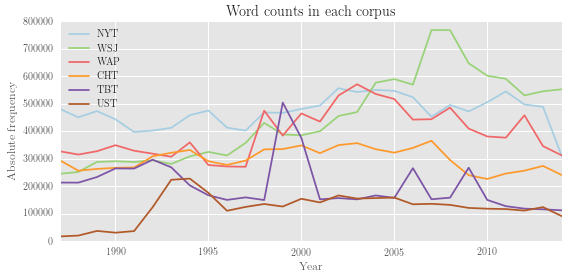

In [11]:
plotter('Word counts in each corpus', allwords.results)

So, the word counts vary between papers, and across time. It's important that we always remember to deal with that issue. One way to do this is to make these into relative frequencies:

In [13]:
rel = editor(allwords.results, '%', allwords.totals)


***Processing results***

***Done!***



In [14]:
rel.results

,NYT,WSJ,WAP,CHT,TBT,UST
1987,30.47,15.53,20.71,18.66,13.51,1.12
1988,29.86,16.71,20.90,17.01,14.14,1.38
1989,29.16,17.76,20.16,16.20,14.38,2.32
1990,26.92,17.66,21.21,16.22,16.08,1.91
1991,25.07,18.19,20.77,16.93,16.68,2.34
1992,23.06,16.88,18.25,17.71,16.99,7.11
1993,22.72,15.49,16.93,17.72,14.81,12.32
...,...,...,...,...,...,...
2008,21.22,32.87,20.81,12.65,6.79,5.67
2009,21.87,29.99,18.98,11.14,12.40,5.63


Then, we can plot again:

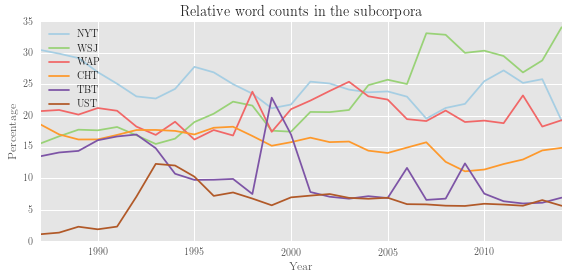

In [15]:
plotter('Relative word counts in the subcorpora', rel.results)

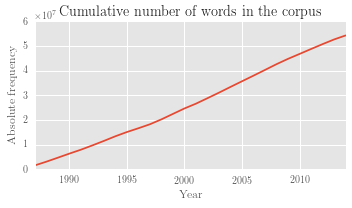

Total: 54288152 words!


In [371]:
# or, we could view this data cumulatively!
plotter('Cumulative number of words in the corpus', allwords.totals, 
        cumulative = True, figsize = (5,3))
print 'Total: %d words!' % allwords.totals.sum()

So, we have a fairly consistently sized dataset, with one major notable caveat: we have little data from USA Today until 1993. That's worth bearing in mind. Generally, we'll use relative frequencies, instead of absolute frequencies, in order to normalise our counts a little better.

`allwords`, was simply counting tokens. As such, it could return a single dataframe as output. The other searches return dictionaries, with corpus names as keys and results as values:

In [11]:
print type(riskwords)
print type(riskwords['UST'])
print type(riskwords['UST'].results)
riskwords['UST'].results

<type 'dict'>
<class 'corpkit.other.loaded_interrogation'>
<class 'pandas.core.frame.DataFrame'>


,risk,risks,risky,...,risk-laden,risk-junkie,#risk
1987,259,94,55,...,0,0,0
1988,339,105,55,...,0,0,0
1989,398,147,64,...,0,0,0
1990,423,105,76,...,0,0,0
1991,469,134,82,...,0,0,0
1992,1660,530,231,...,0,0,0
1993,1770,430,178,...,0,0,0
1994,1749,545,295,...,0,0,0
1995,1606,412,234,...,0,0,0
1996,1556,442,195,...,0,0,0


Each dictionary entry also has a totals count:

In [12]:
riskwords['WSJ'].totals

1987     4439
1988     4458
1989     5328
1990     5361
1991     5350
1992     5332
1993     5094
1994     5684
1995     5893
1996     5462
1997     6140
1998     7667
1999     6813
2000     6722
2001     6683
2002     7874
2003     8172
2004     9970
2005    10485
2006    10305
2007    14022
2008    14527
2009    13273
2010    12580
2011    12202
2012    11057
2013    11292
2014    11490
Name: Total, dtype: int64

If we want to visualise these totals, we can make a simply helper function to concatenate totals:

In [372]:
def get_totals(interrogation):
    """helper function: get totals from dict of interrogations"""
    lst = []
    for k, v in interrogation.items():
        tot = v.totals
        tot.name = k.upper()
        lst.append(tot)
    return pd.concat(lst, axis = 1)

In [13]:
rwt = get_totals(riskwords)
rwt

,WSJ,TBT,NYT,UST,CHT,WAP
1987,4439,4474,7905,475,6113,5832
1988,4458,4309,7588,579,5463,5997
1989,5328,4533,7967,697,5667,5977
1990,5361,4265,8271,685,5715,6204
1991,5350,4253,7430,783,6048,5800
1992,5332,4253,7271,2710,7039,5738
1993,5094,4065,7320,2677,7439,5633
1994,5684,3818,7485,2927,7723,6395
1995,5893,2803,7502,2588,6816,4748
1996,5462,2706,7351,2526,6446,4481


We might now like to determine the percentage of all words that are risk words in each newspaper:



***Processing results***

***Done!***



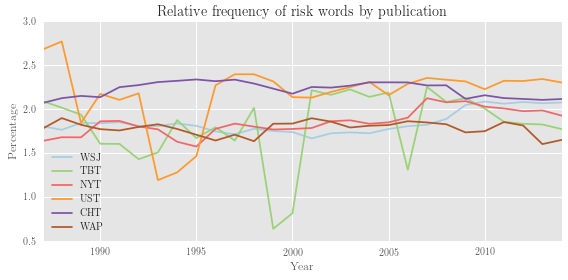

In [27]:
rel = editor(rwt, '%', allwords.results)
plotter('Relative frequency of risk words by publication', rel.results)

Because we extracted paragraphs containing risk words, we can have little to say about whether these dips reflect changes in the relative frequency of risk language, or some other feature, such as paragraph size.

## POS tags

A good starting point is to find out whether there is any change in the most common POS tags for risk words.


***Processing results***

***Done!***



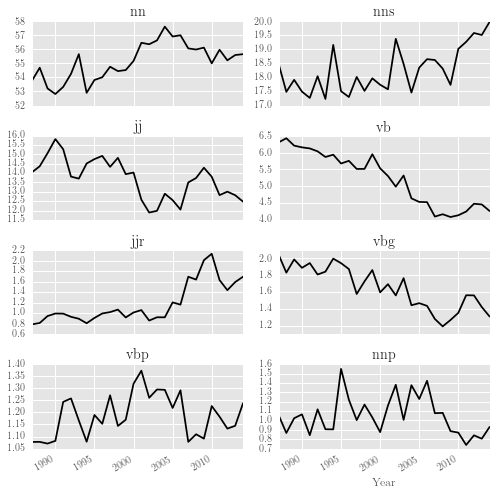

In [310]:
tags = collapsed(risktags)
rel_tags = editor(tags, '%', 'self')
plotter('Most common POS tags for risk words', rel_tags.results, 
        subplots = True, num_to_plot = 8, figsize = (7, 7), layout = (4, 2))

## Word classes

Next, we can try collapsing the distinction between kinds of nouns, adjectives, adverbs and verbs.

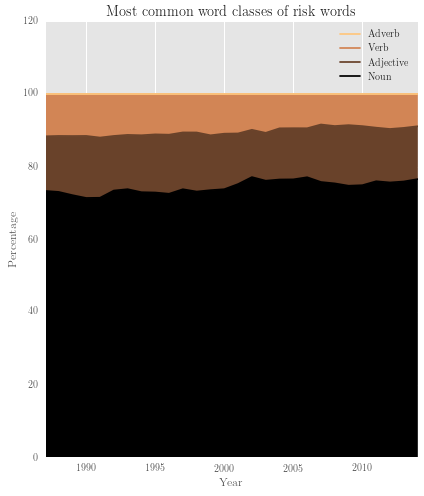

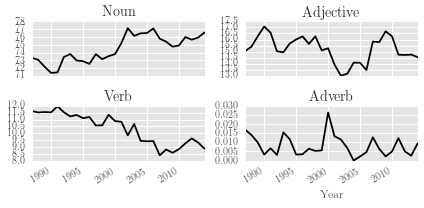

In [376]:
classes = collapsed(riskclasses)
rel_classes = editor(classes, '%', 'self', print_info = False)
plotter('Most common word classes of risk words', rel_classes.results, 
          kind = 'area', figsize = (6,7), colours = 'copper')
plotter('Most common word classes of risk words', rel_classes.results, 
        subplots = True, num_to_plot = 4, figsize = (6, 3), layout = (2, 2))

The clearest trends are toward nominalisation and away from verbal risk. Let's look at how they behave longitudinally in each publication:

Relative frequency of nouns:


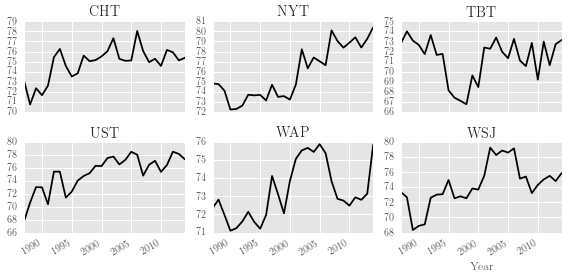

Relative frequency of verbs:


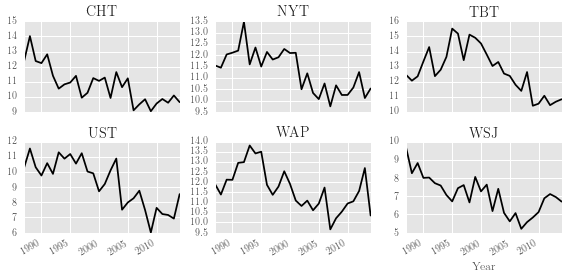

In [329]:
for cls in ['Noun', 'Verb']:
    print 'Relative frequency of %ss:' %cls.lower()
    in_each = entry_across_corpora(riskclasses, cls)
    rel = editor(in_each, '%', get_totals(riskwords), print_info = False)
    plotter('Relative frequency of %ss' %cls, rel.results, subplots = True, layout = (2,3), figsize = (8,4))

The limitation of this kind of approach is that word classes and POS tags are formal features. Though they correlate with semantics (as nouns are likely to be *things*), it is a fairly loose correlation: *to run a risk* features a nominal risk, but semantically, it is not really a thing.

## Using dependencies

We can also look at risk words by dependency role. Dependency roles are closer to functional than formal labels. Below, we get the dependency function of every risk word.

In [ ]:
funct = interrogator(all_corpora, 'function', riskword, quicksave = '6_riskfunct')

### Finding functions undergoing trajectory shift

We can use `funct`, alongside linear regress models, to determine which functions of risk words according to dependency grammar are undergoing longitudinal shifts in relative frequency. First, we can collapse the distinction between newspapers using a helper function:

In [389]:
def collapsed(interrogation):
    import pandas as pd
    order = list(interrogation.values()[0].results.columns)
    df = interrogation.values()[0].results
    for i in interrogation.values()[1:]:
        df = df.add(i.results, fill_value = 0)
    return df[order]

In [332]:
coll_funct = collapsed(funct)
inc = editor(coll_funct, '%', 'self', sort_by = 'increase', keep_top = 10, 
             keep_stats = True, remove_above_p = True, print_info = False)
#dec = editor(coll_funct, '%', 'self', sort_by = 'decrease', keep_top = 10, 
             #keep_stats = True, remove_above_p = True, print_info = False)

In [333]:
inc.results

,dobj,amod,advmod,parataxis,...,advcl,ccomp,root,xcomp
1987,41.78,8.79,0.16,0.48,...,2.01,4.55,5.32,12.56
1988,42.03,9.43,0.13,0.46,...,2.11,4.14,5.44,12.68
1989,41.13,9.97,0.12,0.53,...,1.99,4.17,5.38,12.71
1990,40.74,10.72,0.11,0.50,...,2.07,4.44,5.57,12.19
1991,40.55,10.81,0.13,0.52,...,2.09,4.63,5.15,12.48
1992,41.19,10.11,0.13,0.43,...,2.02,4.57,5.34,12.48
1993,42.81,9.42,0.13,0.57,...,2.10,4.13,5.65,11.94
...,...,...,...,...,...,...,...,...,...
2013,45.16,11.54,0.08,0.45,...,1.62,3.95,4.50,10.13
2014,44.53,11.63,0.08,0.43,...,1.54,3.64,4.16,10.50


Interestingly, there are only two functions in which risk is increasingly common: `dobj` (direct object) and `amod` (adjectival modifier). Looking to the right-hand columns, we can see those results decreasing most in frequency. These display a striking patten: the top four results are each examples of risk as a process/predicator in either a main or embedded clause. This confirms to the results from our pilot study, where risk in the NYT was seen to shift out of predicatorial roles.

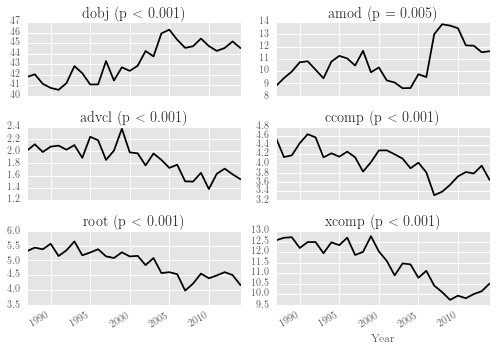

In [358]:
fg = plotter('Functions of risk words undergoing longitudinal shifts', inc.results[[0,1,-4,-3,-2,-1]], tex = True, 
        num_to_plot = 6, subplots = True, figsize = (7,5), layout = (3,2), show_p_val = True)

Next, let's try grouping these into systemic-functional categories. We can access wordlists corresponding to systemic categories as follows:

In [14]:
print roles._asdict().keys()

['actor', 'adjunct', 'auxiliary', 'circumstance', 'classifier', 'complement', 'deictic', 'epithet', 'event', 'existential', 'goal', 'modal', 'numerative', 'participant', 'participant1', 'participant2', 'polarity', 'predicator', 'process', 'qualifier', 'subject', 'textual', 'thing']


The code below converts the functions to systemic labels using `editor()`. `editor()` can receive either a results attribute as its main input, or a `dict` object outputted by `interrogator()`. In the case of the latter, it outputs another `dict` object.

In [12]:
merges = {'Participant': roles.participant,
          'Process': roles.process,
          'Modifier': roles.circumstance + roles.epithet + roles.classifier}

sysfunc = editor(funct, merge_entries = merges, just_entries = merges.keys())


***Processing results***

Merging 93 entries as "Modifier":
    advmod
    nmod:about
    nmod:above
    nmod:across
    nmod:after
    nmod:against
    nmod:ahead_of
    nmod:along
    nmod:along_with
    nmod:alongside
... and 83 more ... 

Merging 7 entries as "Participant":
    appos
    csubj
    csubjpass
    dobj
    iobj
    nsubj
    nsubjpass

Merging 3 entries as "Process":
    advcl
    ccomp
    root

Keeping 3 entries:
    Process
    Modifier
    Participant

***Done!***


10:37:48: Finished! Output is a dictionary with keys:

         'CHT'
         'NYT'
         'TBT'
         'UST'
         'WAP'
         'WSJ'



We can then plot a single newspaper by absolute or relative frequencies:

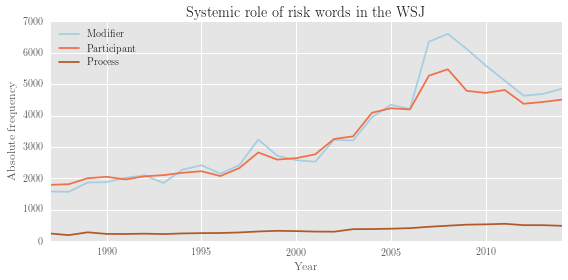

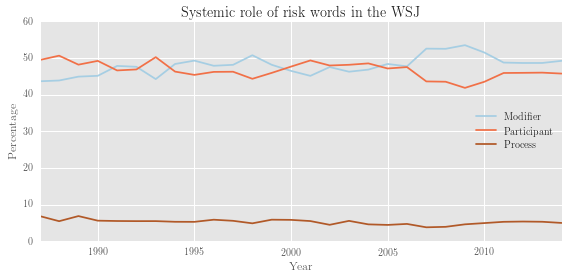

In [13]:
plotter('Systemic role of risk words in the WSJ', sysfunc['WSJ'].results)
rel_sysfunc = editor(sysfunc, '%', 'self', print_info = False)
plotter('Systemic role of risk words in the WSJ', rel_sysfunc['WSJ'].results)

Or, we can look at the behaviour of a given role in every paper. To do this, let's write a simple function that extracts an entry from each result and concatenates the output:

In [359]:
def entry_across_corpora(result_dict, entry_name, regex = False):
    import pandas as pd
    import re
    res = []
    # for each corpus name and data
    for k, v in sorted(result_dict.items()):
        # grab the process result for each paper
        if not regex:
            try:
                column = v.results[entry_name]
            except:
                continue
        else:
            column = v.results[[c for c in list(v.results.columns) if re.search(entry_name, c)]].iloc[:,0]
        # rename it to the corpus name
        column.name = k
        # append to a list
        res.append(column)
    # concatenate and return
    return pd.concat(res, axis = 1)

In [360]:
proc = entry_across_corpora(sysfunc, 'Process')
proc

,CHT,NYT,TBT,UST,WAP,WSJ
1987,392,782,300,32,362,250
1988,397,759,265,42,371,197
1989,358,779,287,44,390,287
1990,347,872,300,45,427,235
1991,424,716,298,55,410,234
1992,421,848,288,169,420,243
1993,445,763,286,188,436,231
...,...,...,...,...,...,...
2008,366,876,230,134,465,497
2009,282,878,357,108,382,530



***Processing results***

***Done!***



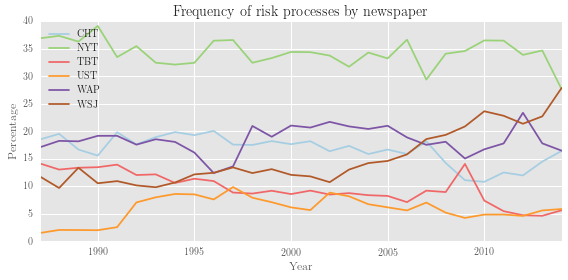

In [361]:
rel_proc = editor(proc, '%', riskwords)
plotter('Frequency of risk processes by newspaper', rel_proc.results, legend = 'or')

Well, that's rather hard to make sense of. A problem with this kind of analysis of risk as process, however, is that it misses risk processes where risk is a noun, not a verb:
    
    1. They took a risk
    2. They ran a risk
    3. It posed a risk
    4. They put it at risk
 
One of our search options, 'governor', can distinguish between these accurately. The query below shows us the function of risk words, and the lemma form of their governor.

In [ ]:
govrole = interrogator(all_corpora, 'g', riskword, lemmatise = True, 
                       dep_type = 'collapsed-ccprocessed-dependencies', quicksave = '6_govrole')

We can now fix up our earlier count of risk by functional role. It's tricky, but shows the power of `editor()` and `pandas`:

In [234]:
# make a copy, to be safe
from copy import deepcopy
syscopy = deepcopy(sysfunc)

# for each corpus
for k, v in syscopy.items():
    # calculate number to add to process count
    are_proc = ['dobj:run', 'dobj:take', 'dobj:pose', 'nmod:at:put', 'prep_at:put']
    add_to_proc = govrole[k].results[[i for i in are_proc if i in govrole[k].results.columns]].sum(axis = 1)
    # calculate number to subtract from participant count
    subtract_from_part = govrole[k].results[['dobj:run', 'dobj:take', 'dobj:pose']].sum(axis = 1)
    # calculate number to subtract from modifier count
    submod = ['prep_at:put', 'nmod:at:put']
    subtract_from_mod = govrole[k].results[[i for i in submod if i in govrole[k].results.columns]].sum(axis = 1)
    # do these calculations
    v.results['Process'] = v.results['Process'] + add_to_proc
    v.results['Participant'] = v.results['Participant'] - subtract_from_part
    v.results['Modifier'] = v.results['Modifier'] - subtract_from_mod

In [235]:
print 'Uncorrected:'
print sysfunc['NYT'].results
print 'Corrected:'
print syscopy['NYT'].results

Uncorrected:
      Modifier  Participant  Process
1987      2838         3107      782
1988      2763         2914      759
1989      2751         3148      779
1990      2914         3098      872
1991      2652         2851      716
1992      2474         2806      848
1993      2568         2893      763
...        ...          ...      ...
2008      4039         4244      876
2009      3771         4033      878
2010      4048         4143      834
2011      4219         4540      892
2012      3932         3869      815
2013      3752         3940      785
2014      2412         2443      490

[28 rows x 3 columns]
Corrected:
      Modifier  Participant  Process
1987      2742         2418     1567
1988      2668         2311     1457
1989      2653         2519     1506
1990      2799         2473     1612
1991      2534         2226     1459
1992      2360         2193     1575
1993      2473         2300     1451
...        ...          ...      ...
2008      3835         3420 

Let's look at the frequencies of each of these risk processes:

Now, let's plot more accurately, by role, and then by paper:

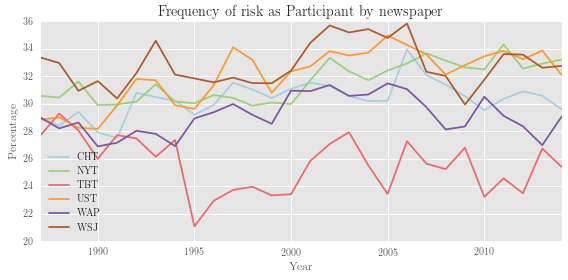

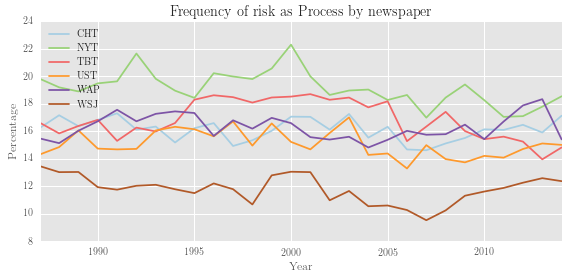

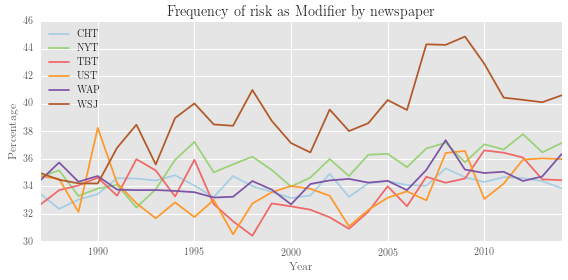

In [178]:
for role in ['Participant', 'Process', 'Modifier']:
    df = entry_across_corpora(syscopy, role)
    edi = editor(df, '%', get_totals(riskwords), print_info = False)
    plotter('Frequency of risk as %s by newspaper' % role, edi.results)

In [21]:
def rel(interrogation):
    """make relative version of results for quick plotting"""
    import pandas
    from corpkit import editor
    if type(interrogation) == dict or type(interrogation) == pandas.core.frame.DataFrame:
        return editor(interrogation, '%', 'self')
    else:
        return editor(interrogation.results, '%', 'self')

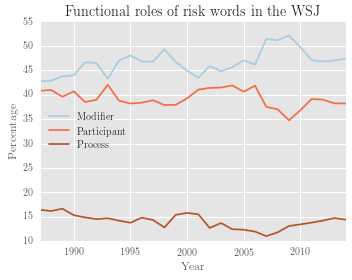

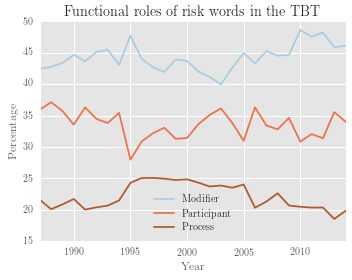

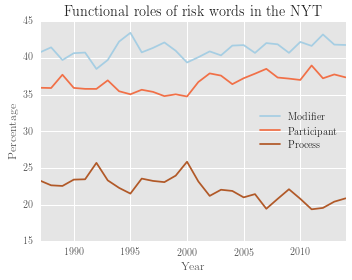

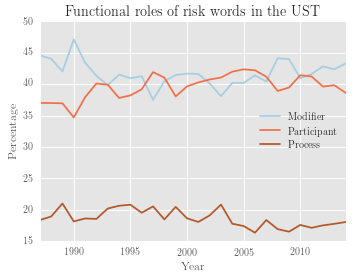

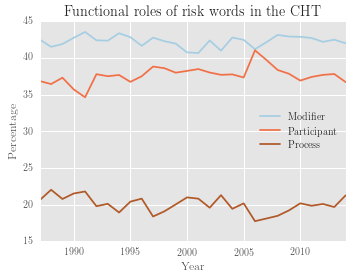

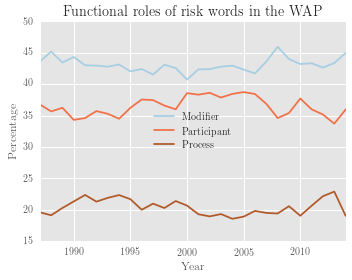

In [247]:
for name, data in syscopy.items():
    rel_data = editor(data.results, '%', 'self', print_info = False)
    plotter('Functional roles of risk words in the %s' % name, rel_data.results, figsize = (5, 4))

In [248]:
collapsed(syscopy)

,Modifier,Participant,Process
1987,9973,8742,4873
1988,9769,8455,4653
1989,10168,9016,4943
1990,10439,8737,5071
1991,10238,8505,4920
1992,11198,9720,5403
1993,11024,9809,5337
...,...,...,...
2008,18229,14518,6824
2009,16770,13235,6687


Participant


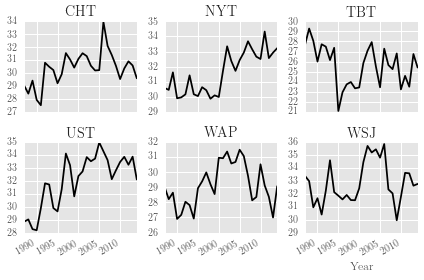

Process


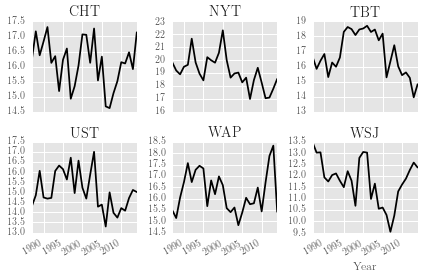

Modifier


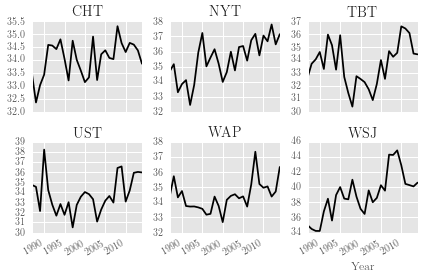

In [252]:
tot = get_totals(riskwords)
for entry in ['Participant', 'Process', 'Modifier']:
    en = entry_across_corpora(syscopy, entry)
    rel_en = editor(en, '%', tot, print_info = False)
    print entry
    plotter('X', rel_en.results, subplots = True, figsize = (6,4), layout = (2,3))

We can see that basic trends observed in the NYT, away from risk processes and toward risk participants and modifiers, hold true to some extent amongst other mainstream U.S. publications. This is especially so in the case of risk-as-modifiers, which are increasingly common in every publication sampled.

That said, the trends are not always as clear cut in other newspapers as they are in the NYT.

## Risk processes

The next thing we can do with our `govrole` interrogation is to plot the frequencies of the five identified risk processes. To do this, we can rename the combination of role and governor to something more readable, and then remove all other entries:

In [264]:
renames = {'to risk': 'root:root',
           'to run risk':'dobj:run',
           'to take risk': 'dobj:take',
           'to pose risk': 'dobj:pose',
           'to put at risk': 'nmod:at:put'}

# nyt was parsed with a slightly different grammar. 
# this standardises 'put at risk'
govrole['NYT'].results.rename(columns={'prep_at:put': 'nmod:at:put'}, inplace=True)

risk_processes = editor(govrole, replace_names = renames, 
                               just_entries = renames.keys(), sort_by = 'total')


***Processing results***

Replacing "root:root" with "to risk" ...

Replacing "nmod:at:put" with "to put at risk" ...

Replacing "dobj:take" with "to take risk" ...

Replacing "dobj:run" with "to run risk" ...

Replacing "dobj:pose" with "to pose risk" ...

Merging duplicate entries ... 

Keeping 5 entries:
    to risk
    to put at risk
    to take risk
    to run risk
    to pose risk

***Done!***


15:15:22: Finished! Output is a dictionary with keys:

         'CHT'
         'NYT'
         'TBT'
         'UST'
         'WAP'
         'WSJ'



Let's take a look at what we have:

In [265]:
print risk_processes['WAP'].results

      to take risk  to risk  to put at risk  to pose risk  to run risk
1987           274      141              53            88          126
1988           251      142              65            97          124
1989           265      148              96           109           99
1990           273      181              97           119          122
1991           267      176             105           113          124
1992           252      175              94            94          100
1993           246      182             100            70          121
...            ...      ...             ...           ...          ...
2008           397      193             225           213          106
2009           340      169             171           182          100
2010           267      173             192           133           57
2011           296      192             205           158           75
2012           410      260             273           161           83
2013  

Displaying all this information properly is tricky. First, we can try collapsing distinctions between subcorpora---though this means that we can't observe longitudinal change:

In [266]:
out = []
for k, v in risk_processes.items():
    data = v.results.sum(axis = 0)
    data.name = k
    out.append(data)
collapsed_years = pd.concat(out, axis = 1)
print collapsed_years

                 WSJ   TBT    NYT   UST   CHT   WAP
to pose risk    3459  1807   4174  1165  3157  3797
to put at risk  2849  2563   4614  1761  4009  4641
to risk         4194  2943  11247  2068  4817  5285
to run risk     2365  1306   3471   833  2739  2973
to take risk    8358  4110  11391  3057  9007  8159


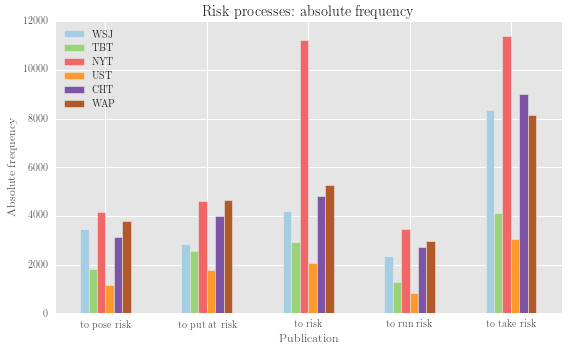

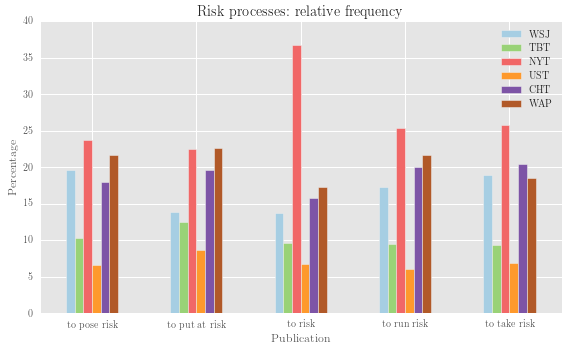

In [274]:
plotter('Risk processes: absolute frequency', collapsed_years, kind = 'bar', rot = False, 
        x_label = 'Publication', figsize = (8, 5))
rel_proc = editor(collapsed_years, '%', 'self', print_info = False)
plotter('Risk processes: relative frequency', rel_proc.results,
                                kind = 'bar', rot = False, x_label = 'Publication', figsize = (8, 5))

Or, we can collapse the distinction between newspapers. Perhaps we could make another function for this:

In [269]:
def collapsed(interrogation):
    import pandas as pd
    order = list(interrogation.values()[0].results.columns)
    df = interrogation.values()[0].results
    for i in interrogation.values()[1:]:
        df = df.add(i.results, fill_value = 0)
    df = df[order]
    return df

      to take risk  to risk  to pose risk  to put at risk  to run risk
1987          1367      948           484             338          566
1988          1338      945           426             320          538
1989          1375     1000           519             423          481
1990          1349     1026           525             431          540
1991          1308      927           482             440          553
1992          1534     1070           477             497          506
1993          1466     1117           469             499          554
...            ...      ...           ...             ...          ...
2008          1977     1189           853             949          477
2009          1914     1187           809             985          442
2010          1687     1057           711             971          352
2011          1639     1105           766             873          366
2012          1711     1096           692             961          374
2013  

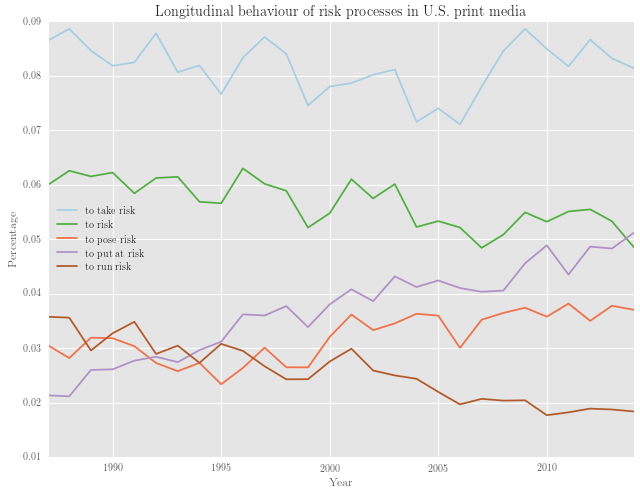

In [273]:
print collapsed(risk_processes)
ed = editor(collapsed(risk_processes), '%', allwords.totals, print_info = False)
plotter('Longitudinal behaviour of risk processes in U.S. print media', ed.results, figsize = (9, 7))

We can see whether this pattern is similar for each newspaper:

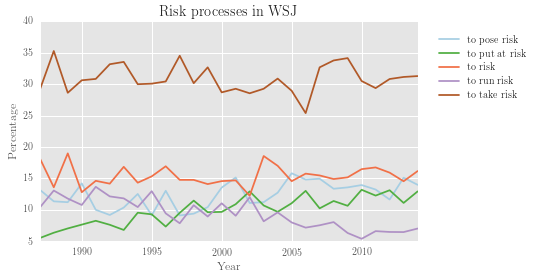

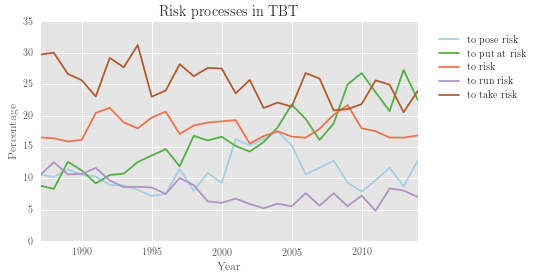

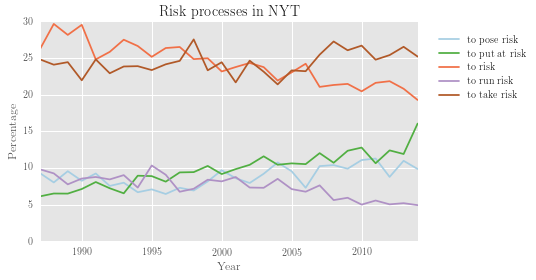

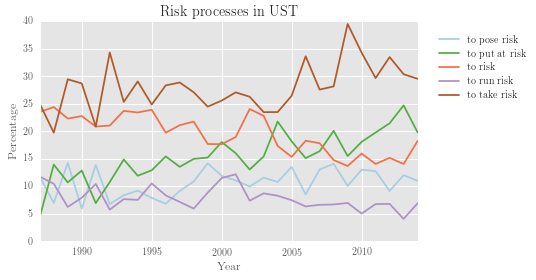

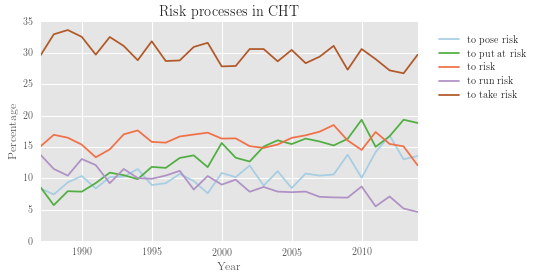

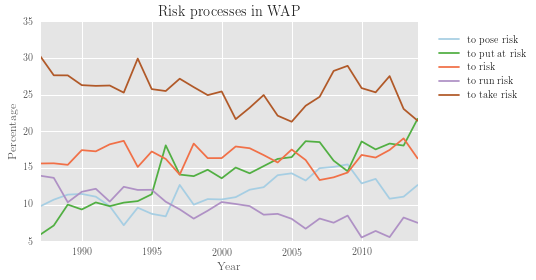

In [243]:
for name, data in govrole.items():
    res = editor(govrole[name].results, '%', syscopy[name].results['Process'], sort_by = 'name',
                       replace_names = renames, just_entries = renames.keys(), print_info = False)
    plotter('Risk processes in %s' % name, res.results,
            figsize = (6,4), legend_pos = 'outside right')

Let's look a little closer, and see whether the trend toward `to put at risk` and away from `to run risk` is reflected in every publication:

to put at risk

13:30:37: images/to-put-at-risk.png created.


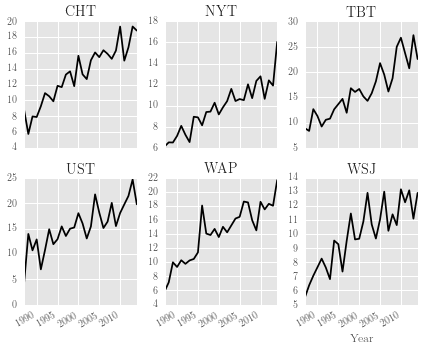

to run risk

13:30:41: images/to-run-risk.png created.


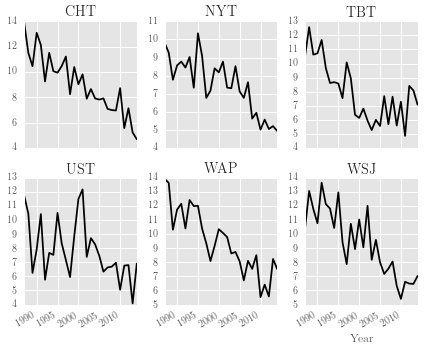

In [377]:
lst = []
renames = {#'to risk': 'root:root',
           'to run risk':'dobj:run',
           #'to take risk': 'dobj:take',
           #'to pose risk': 'dobj:pose',
           'to put at risk': r'(nmod:at:put|prep_at:put)'}
for n, i in renames.items():
    ent = entry_across_corpora(govrole, i, regex = True)
    rel_ent = editor(ent, '%', entry_across_corpora(syscopy, 'Process'), print_info = False)
    print n
    plotter(n, rel_ent.results, subplots = True, layout = (2, 3), figsize = (6, 5), save = True)

Indeed, some patterns seem quite regular. *Running risk* decreases in every publication, and *put at risk* increases.

### Risk as classifier/pre-head modifier

We also found growth in the use of risk as a nominal pre-head modifier (*risk factor*, *risk brokerage*, etc.). We can use the same interrogation to find out what risk modifies in this way:

In [38]:
# this is a bit of a hack: delete nnmod: from names, then remove 
# any entry with a ':' in it
nom_mod = editor(govrole, '%', riskwords, replace_names = r'^(nn|compound):', 
                 skip_entries = r':', use_df2_totals = True)


***Processing results***

Replacing "^(nn|compound):" with "" ...

Merging duplicate entries ... 

Skipping 25208 entries:
    nsubj:be
    xcomp:be
    dobj:take
    nmod:at:be
    dobj:reduce
    root:root
    dobj:pose
    nmod:at:put
    dobj:increase
    dobj:carry
... and 25198 more ... 

***Done!***


10:45:35: Finished! Output is a dictionary with keys:

         'CHT'
         'NYT'
         'TBT'
         'UST'
         'WAP'
         'WSJ'



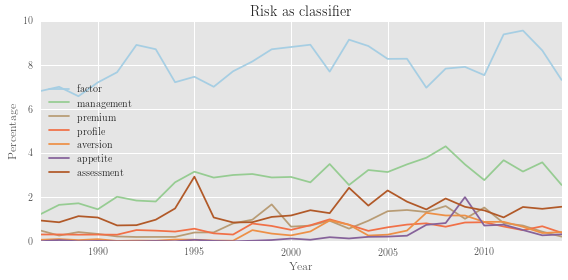

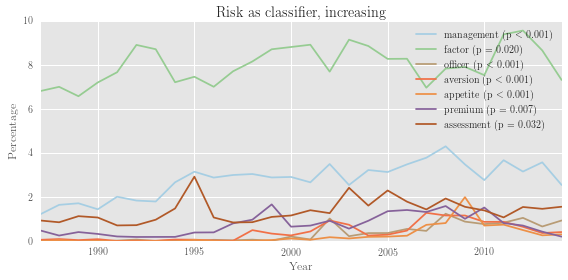

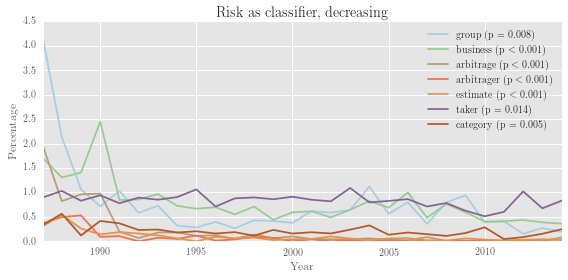

In [390]:
inc_class = editor(collapsed(nom_mod), sort_by = 'increase', keep_stats = True, print_info = False)
dec_class = editor(collapsed(nom_mod), sort_by = 'decrease', keep_stats = True, print_info = False)
plotter('Risk as classifier', collapsed(nom_mod))
plotter('Risk as classifier, increasing', inc_class.results, show_p_val = True)
plotter('Risk as classifier, decreasing', dec_class.results, show_p_val = True)

`Risk group` drops from extremely high prevalence due to its use during the beginning of the HIV/AIDS epidemic:

In [285]:
lines = conc('data/WAP/1987', 't', r'NP << /(?i)\brisk/ <<# /(?i)group/', print_output = False)
lines[['l', 'm', 'r']]

,l,m,r
0,Consumers ``are seeing that they can get a whole lot better deal f...,a risk-retention group,"than a private insurance company, ''Angoff said."
1,"By focusing on the New York gay scene in 1976, Shilts makes a subt...",the group at highest risk,": young, homosexual men."
2,Simply because the majority of Africans are black does not imply t...,this high-risk group,is a racist act.
3,"The preoccupation with AIDS has affected lesbians,",the group at lowest risk,"for the disease, which is transmitted through blood and semen."
4,$65 million for educational campaigns targeted at,high-risk groups and the general population,.
5,"To begin with, the available evidence suggests that schoolchildren...",a high-risk group,.
6,``If there is such a thing as,a high risk group,", it's teen-agers, ''said David Brumbach, a former urban planner w..."
...,...,...,...
182,"As the pool of infected people widens, AIDS experts fear that the ...",the narrowly defined risk groups,.
183,Homosexual males are one of,the groups at highest risk,of contracting AIDS.


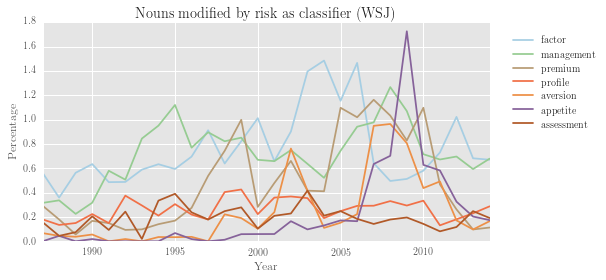

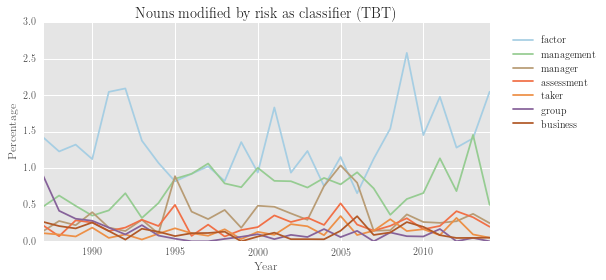

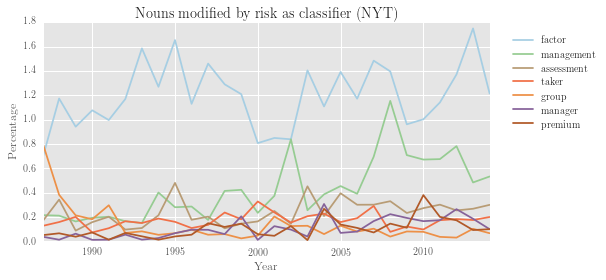

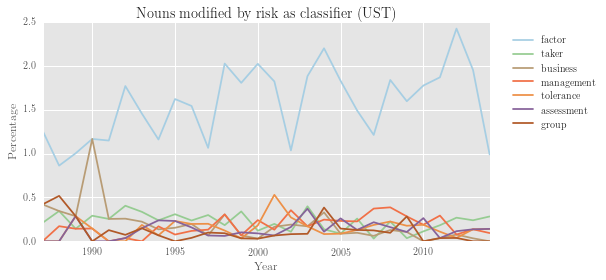

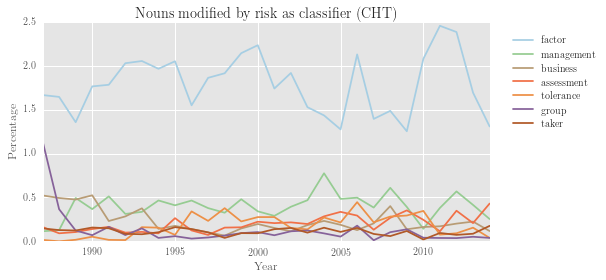

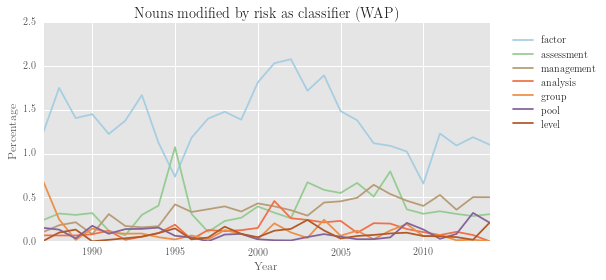

In [364]:
for k, v in nom_mod.items():
    plotter('Nouns modified by risk as classifier (%s)' % k, v.results, figsize = (7, 4), legend_pos = 'outside right')

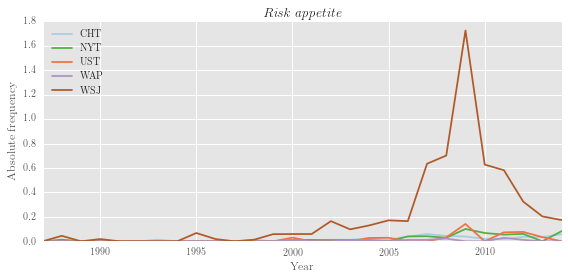

In [366]:
plotter('\emph{Risk appetite}', entry_across_corpora(nom_mod, 'appetite'), legend_pos = 'upper left')

In [295]:
lines = conc('data/WSJ/2009', 't', r'NP < (/NN.?/ < /(?i)\brisk/) < (/NN.?/ < /(?i)\bappetit/)', print_output=False)
lines[['l', 'm', 'r']]

,l,m,r
0,The modest retreat ensued as stock markets recovered from initial ...,global risk appetites,remained stable.
1,Hopes are high for,risk appetite,"to build this week, which would boost the euro and hurt the yen, ..."
2,"By some measures, the company did increase",its risk appetite,.
3,The euro gained ground against the dollar and the yen as,risk appetite,returned to global financial markets after the U.S. government ex...
4,,Depressed overall risk appetite,also sent the euro lower against the safe-haven U.S. currency on ...
5,"That optimism, in turn, is boosting",risk appetite,.
6,The comeback in,risk appetite,was also negative for the dollar against the euro.
...,...,...,...
228,"Here is a model portfolio from Bingham, Osborn &amp; Scarborough f...",a moderate risk appetite,.
229,This not only aids,general risk appetite,", but also should fundamentally improve the economic outlooks in e..."


Risk appetite is a good example of the increasing number of ways in which `risk` is employed in the financial sector.

Still focussing on risk as a classifier, we can find out which words are increasing and decreasing the most over time:

In [ ]:
nom_mod_inc = editor(govrole, replace_names = r'(nn|compound):', skip_entries = ':', 
                     sort_by = 'increase', print_info = False)
nom_mod_dec = editor(govrole, replace_names = r'(nn|compound):', skip_entries = ':', 
                     sort_by = 'decrease', print_info = False)

In [298]:
nom_mod_inc['TBT'].results

,corridor,act,management,officer,...,department,business,factor,group
1987,0.00,0.00,21.00,0.00,...,7.00,12.00,64.00,41.00
1988,0.00,0.00,27.00,0.00,...,2.00,9.00,53.00,18.00
1989,0.00,0.00,22.00,1.00,...,4.00,8.00,60.00,14.00
1990,0.00,0.00,15.00,0.00,...,5.00,11.00,48.00,12.00
1991,0.00,0.00,18.00,0.00,...,5.00,6.00,87.00,8.00
1992,0.00,0.00,28.00,0.00,...,2.00,1.00,89.00,4.00
1993,0.00,0.00,13.00,0.00,...,2.00,7.00,56.00,9.00
...,...,...,...,...,...,...,...,...,...
2008,0.00,0.00,12.00,2.00,...,1.00,4.00,51.00,4.00
2009,0.00,0.00,33.00,0.00,...,2.00,15.00,147.00,4.00


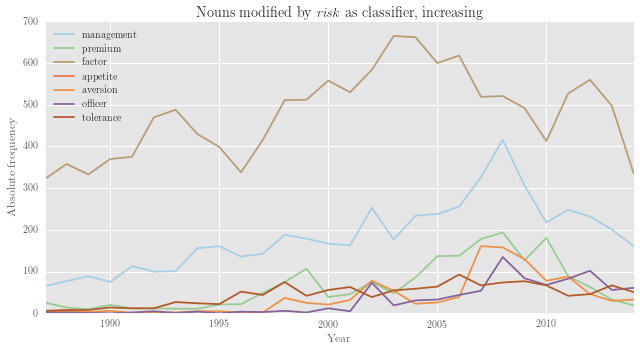

In [305]:
plotter('Nouns modified by \emph{risk} as classifier, increasing', collapsed(nom_mod_inc), 
             legend_pos = 'upper left', figsize = (9, 5), y_label = 'Absolute frequency')

## Adjectival risks

One thing we noticed in our pilot investigation of the NYT was that while some adjectival risk words are declining in frequency (*risky* is a good example), others, like *at-risk* are becoming more prominent. We can check the other newspapers to see if the trend is general:

### Risky, riskier, riskiest

Here, we want to find the percentage of risk-as-modifiers that are risky/riskier/riskier. We can start by conflating the six newspapers.

In [ ]:
risky = interrogator(all_corpora, 'count', r'/(?i)\brisk(y|ier|iest)/', quicksave = '6_risky')

In [31]:
# the overall frequency of risk as modifier
mod = entry_across_corpora(sysfunc, 'Modifier')
mod.sum(axis = 1)

1987    10669
1988    10456
1989    10960
1990    11252
1991    11054
1992    12100
1993    11938
        ...  
2008    19602
2009    18184
2010    16510
2011    16299
2012    16015
2013    15057
2014    13085
dtype: int64

In [32]:
#print risky.results.sum(axis = 1)
#rwt = get_totals(riskwords)
#print rwt
rel_risky_sum = editor(risky.results.sum(axis = 1), '%', mod.sum(axis = 1))
rel_risky_sum.results


***Processing results***

***Done!***



,0
1987,22.43
1988,23.29
1989,24.80
1990,24.79
1991,23.50
1992,22.98
1993,22.92
1994,24.63
1995,24.33
1996,25.99


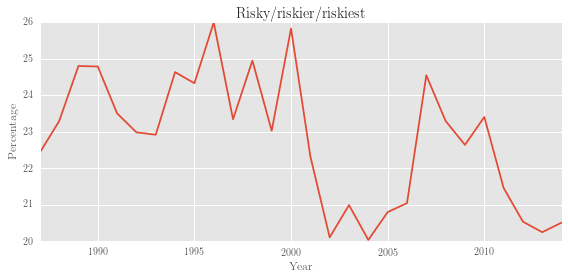

In [33]:
plotter('Risky/riskier/riskiest', rel_risky.results)

Like we found in the NYT, there is an overall decrease. Let's take a look at the individual newspapers:

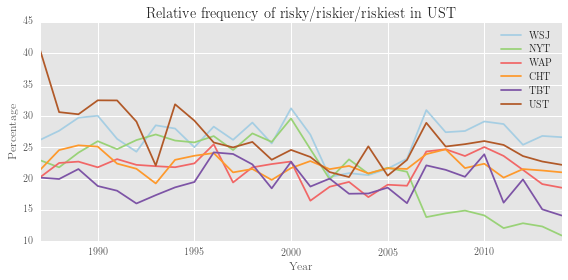

In [38]:
res = []
for paper in list(risky.results.columns):
    ed = editor(risky.results[paper], '%', mod[paper], print_info = False)
    res.append(ed.results)

concatted = pd.concat(res, axis = 1)
plotter('Relative frequency of risky/riskier/riskiest', concatted)

We can see that the trend is not as clear in other papers as it is in the NYT.

### at-risk

We also saw growth in the use of the at-risk modifier. We can check this too:

In [ ]:
atrisk = interrogator(all_corpora, 'count', r'/(?i)\bat-risk/', quicksave = '6_atrisk')

In [48]:
atrisk.results

,WAP,TBT,CHT,NYT,WSJ,UST
1987,26,46,15,17,8,3
1988,60,41,16,29,15,2
1989,70,87,25,11,5,4
1990,78,74,33,20,5,2
1991,99,67,42,19,12,7
1992,89,67,50,14,7,25
1993,67,107,63,16,11,13
...,...,...,...,...,...,...
2008,159,146,106,45,57,20
2009,178,216,122,59,42,30



***Processing results***

***Done!***



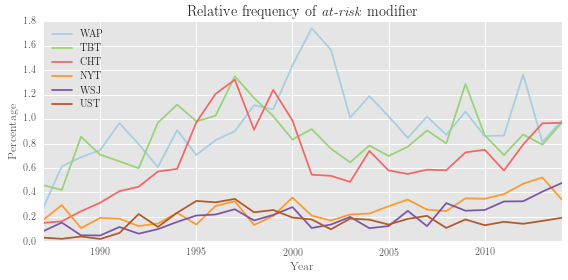

In [52]:
rel_atrisk_sum = editor(atrisk.results, '%', collapsed(syscopy)['Modifier'])
plotter('Relative frequency of \emph{at-risk} modifier', rel_atrisk_sum.results)

Now, let's split the corpora again:

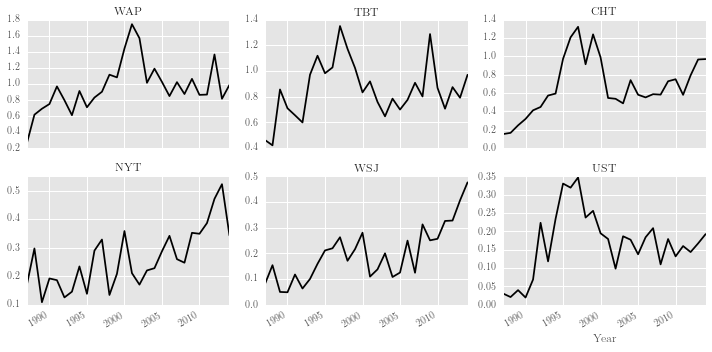

In [59]:
plotter('Relative frequency of \emph{at-risk}', rel_atrisk_sum.results, subplots = True, figsize = (10, 5), layout = (2,3))

Interesting that both the peaks before 9/11 and the general rise are observable in most papers.

## Mood role of risk words

In our last investigation, we found that risk is increasingly occurring within complements and adjuncts, and less often within subject and finite/predicator positions. This was taken as evidence for decreasing arguability of risk in news discourse.

We can attempt to replicate that result using a previous interrogation.



In [ ]:
print roles

In [65]:
# we collapse the finite/predicator distinction because it's not very
# well handled by dependency parses. this is a pity, since finite plays
# a more important role in arguability than predicator.

merges = {'Subject': roles.subject,
          'Finite/Predicator': roles.predicator,
          'Complement': roles.complement,
          'Adjunct': roles.adjunct}

moodrole = editor(funct, merge_entries = merges, just_entries = merges.keys())


***Processing results***

Merging 92 entries as "Adjunct":
    advcl
    advmod
    nmod:about
    nmod:above
    nmod:across
    nmod:after
    nmod:against
    nmod:ahead_of
    nmod:along
    nmod:along_with
... and 82 more ... 

Merging 2 entries as "Complement":
    dobj
    iobj

Merging 2 entries as "Finite/Predicator":
    ccomp
    root

Merging 4 entries as "Subject":
    csubj
    csubjpass
    nsubj
    nsubjpass

Keeping 4 entries:
    Finite/Predicator
    Adjunct
    Complement
    Subject

***Done!***


11:00:15: Finished! Output is a dictionary with keys:

         'CHT'
         'NYT'
         'TBT'
         'UST'
         'WAP'
         'WSJ'



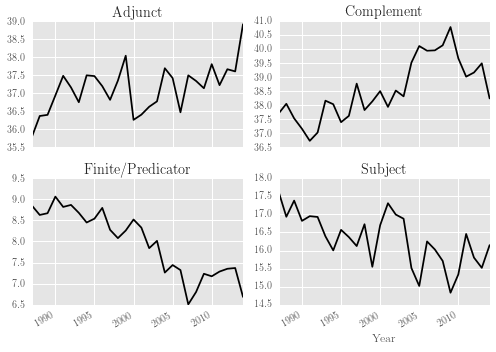

In [368]:
rel_role = editor(collapsed(moodrole), '%', 'self', print_info = False)
#plotter('Mood role of risk words', rel_role.results)
plotter('Mood role of risk words', rel_role.results, 
        subplots = True, layout = (2,2), figsize = (7, 5))

This finding aligns with our pilot study, showing that risk is shifting from more arguable to less arguable positions within clauses.

## Risk and power

The last thing we'll look at (for now) is the relationship beween risking and power.

In our previous analysis, we found that powerful people are much more likely to do risking.

To determine this, we needed to make two search queries. The first finds the nominal heads when risk/run risk/take risk is the process:


In [ ]:
query = r'/NN.?/ !< /(?i).?\brisk.?/ >># (@NP $ (VP <+(VP) (VP ( <<# (/VB.?/ < /(?i).?\brisk.?/) | <<# (/VB.?/ < /(?i)(take|taking|takes|taken|took|run|running|runs|ran)/) < (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))))'
noun_riskers = interrogator(all_corpora, 'words', query, lemmatise = True, quicksave = '6_noun_riskers', num_proc = 3)

Next, we need to get the frequencies of nouns generally, so that we can account for the fact that some nouns are very common.

In [ ]:
query = r'/NN.?/ >># NP !< /(?i).?\brisk.?/'
noun_lemmata = interrogator(all_corpora, 'words', query, lemmatise = True, quicksave = '6_noun_lemmata')

Now, we can combine the lists:

            WSJ  TBT  NYT  UST  CHT  WAP
man        0.50 0.83 0.60 0.26 0.86 0.57
woman      0.40 0.19 0.31 0.28 0.31 0.19
child      0.08 0.14 0.26 0.06 0.14 0.13
baby       0.14  nan 0.06 0.15 0.11 0.06
politician 1.37 1.80 1.83 1.20 0.45 1.52
senator    0.31 0.85 0.66  nan 1.81 0.79
obama      1.50 0.80 2.00 1.77 1.57 0.97
clinton    2.10 1.17 1.40 2.25 1.99 1.55
bush       1.46 0.71 1.45 1.97 3.35 1.23


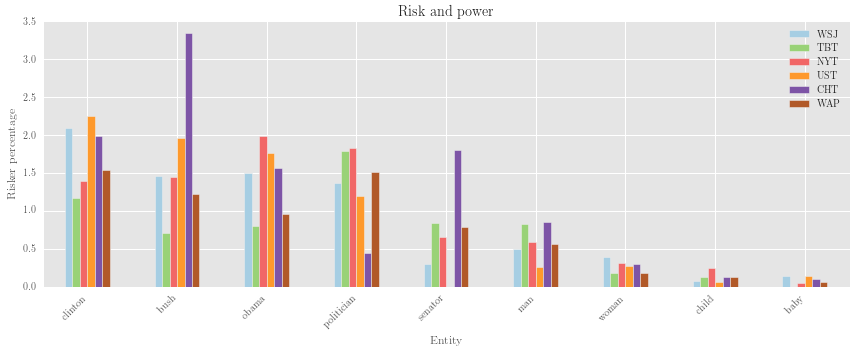

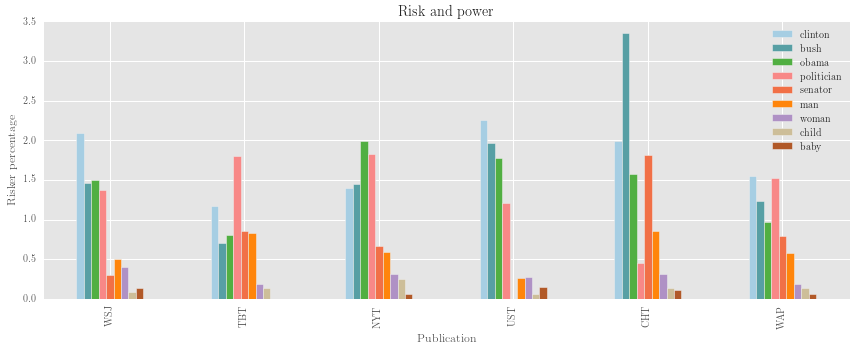

In [150]:
# entities of interest
people = ['man', 'woman', 'child', 'baby', 'politician', 
          'senator', 'obama', 'clinton', 'bush']

# make summed versions of the noun_lemmata data
summed_n_lemmata = {}
for name, data in noun_lemmata.items():
    summed_n_lemmata[name] = data.results.sum(axis = 0)

# calculate percentage of the time word is in 
# risker position for each paper

# newpaper names
cols = []
# the results go here
res = []
# for each newspaper
for name, data in noun_riskers.items():
    # collapse years
    data = data.results.sum(axis = 0)
    # make a new column
    ser = {}
    # for each risker
    for i in list(data.index):
        # if not a hapax
        if summed_n_lemmata[name][i] < 2:
            continue
        # get its percentage
        try:
            sm = data[i] * 100.0 / summed_n_lemmata[name][i]
        except:
            continue
        # add this to the data for this paper
        ser[i] = sm
    
    # turn the data into a column
    as_series = pd.Series(ser)
    # sort it
    as_series.sort(ascending = False)
    # add it to a master list
    res.append(as_series)
    # add the newspaper name
    cols.append(name)
    
# put data together into spreadsheet
df = pd.concat(res, axis = 1)
# name newspapers again
df.columns = cols
# just named entries
df_sel = df.T[people].T
# show us what it looks like
print df_sel
# sort by frequency
sort_by = list(df_sel.sum(axis = 1).sort(ascending = False, inplace = False).index)
df_sel = df_sel.T[sort_by].T

# visualise
plotter('Risk and power', df_sel, kind = 'bar', figsize = (12, 5),
            x_label = 'Entity', y_label = 'Risker percentage')
plotter('Risk and power', df_sel.T, kind = 'bar', figsize = (12, 5), num_to_plot = 'all',
           x_label = 'Publication', y_label = 'Risker percentage')

We can see here that each paper construes powerful people as riskers. Also interesting is that entities favoured by the political orientation of the newspapers are more often positioned as riskers.

Finally, we can look longitudinally, to see if there are more or fewer riskers in general:

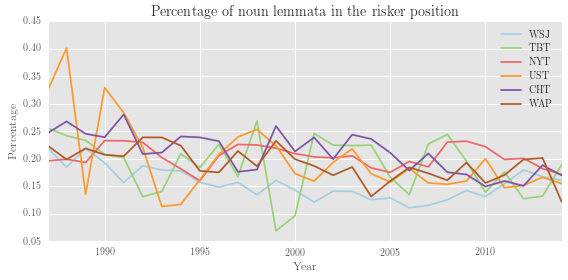

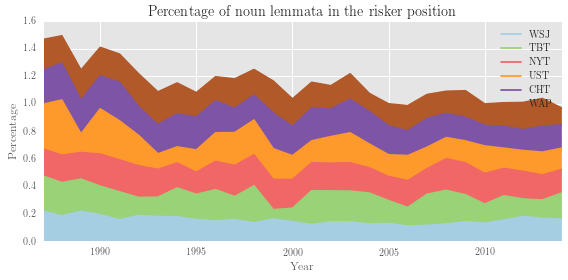

In [166]:
lemmata_tots = {}
for name, data in noun_lemmata.items():
    lemmata_tots[name] = data.totals
output = []
for name, data in noun_riskers.items():
    tot = data.totals
    tot = tot * 100.0 / lemmata_tots[name]
    tot.name = name
    output.append(tot)
df = pd.concat(output, axis = 1)
plotter('Percentage of noun lemmata in the risker position', df)
plotter('Percentage of noun lemmata in the risker position', df, kind = 'area', reverse_legend = False)

So, interestingly, there are fewer and fewer grammatical riskers in mainstream U.S. print news.

## Discussion

* A key issue we faced was turning a mind-boggling amount of data into something more reasonable.
* Typically, the most telling visualisations are those that conflate corpora, conflate sampling periods, or limit findings to a single linguistic feature at a time.
* Being able to programmatically work with data is a huge plus, especially when it has a complex structure

## Next steps

* Computationally, an interesting next step would be to develop algorithsm that rank the importance of various features, in order to condense complex, multidimensional findings into 'scores' for concepts such as implicitness, density, arguability, and the like.
* Sociologically, qualitative analysis of risk words in their immediate co-text and context would also prove valuable.
